#### Instructions:  
1. Libraries allowed: **Python basic libraries, numpy, pandas, scikit-learn (only for data processing), pytorch, and ClearML.**
2. Show all outputs.
3. Submit jupyter notebook and a pdf export of the notebook. Check canvas for detail instructions for the report.
4. Below are the questions/steps that you need to answer. Add as many cells as needed.

In [ ]:
from torchvision import transforms

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from google.colab import drive

cudnn.benchmark = True
plt.ion()

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Task 2: Finetuning a pretrained NN
Do transfer learning with ResNet18 and compare peforamnce with the hyperparamter-tuned network.

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'Train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/DL Project 1/Dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['Train', 'Test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['Train', 'Test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Train', 'Test']}
class_names = image_datasets['Train'].classes

device = torch.device("cuda")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


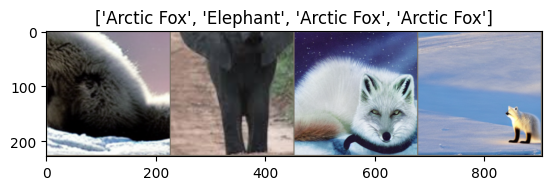

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


inputs, classes = next(iter(dataloaders['Train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['Train', 'Test']:
                if phase == 'Train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'Train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'Train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'Train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'Test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['Test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
for param in model_ft.parameters():
    param.requires_grad = False
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
Train Loss: 0.2611 Acc: 0.8914
Test Loss: 0.0010 Acc: 1.0000

Epoch 1/24
----------
Train Loss: 0.2734 Acc: 0.9039
Test Loss: 0.0012 Acc: 1.0000

Epoch 2/24
----------
Train Loss: 0.2762 Acc: 0.9001
Test Loss: 0.0051 Acc: 1.0000

Epoch 3/24
----------
Train Loss: 0.2137 Acc: 0.9238
Test Loss: 0.0020 Acc: 1.0000

Epoch 4/24
----------
Train Loss: 0.1644 Acc: 0.9376
Test Loss: 0.0049 Acc: 1.0000

Epoch 5/24
----------
Train Loss: 0.2958 Acc: 0.8851
Test Loss: 0.0001 Acc: 1.0000

Epoch 6/24
----------
Train Loss: 0.1753 Acc: 0.9288
Test Loss: 0.0087 Acc: 0.9950

Epoch 7/24
----------
Train Loss: 0.1913 Acc: 0.9263
Test Loss: 0.0008 Acc: 1.0000

Epoch 8/24
----------
Train Loss: 0.1877 Acc: 0.9301
Test Loss: 0.0037 Acc: 1.0000

Epoch 9/24
----------
Train Loss: 0.1582 Acc: 0.9301
Test Loss: 0.0066 Acc: 1.0000

Epoch 10/24
----------
Train Loss: 0.1360 Acc: 0.9501
Test Loss: 0.0018 Acc: 1.0000

Epoch 11/24
----------
Train Loss: 0.2339 Acc: 0.8976
Test Loss: 0.0021 Acc

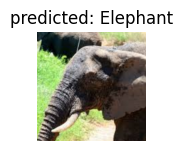

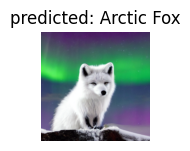

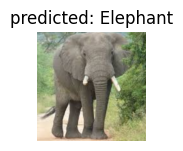

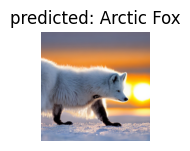

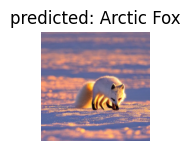

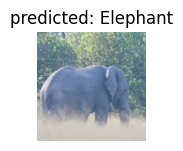

In [ ]:
visualize_model(model_ft)

### Discussion
Provide a comparative analysis.

### 1. Baseline Hyperparameter-Tuned CNN
- Architecture: Custom-built CNN with dynamically configurable parameters (layers, filters, etc.).
- Performance:
  - Achieved 70% accuracy, 81% precision, 70% recall, and 67% F1 score on the test dataset.
  - Demonstrated a balance between learning and generalization, avoiding overfitting.
- Strengths:
  - The flexible design allows for systematic hyperparameter tuning using ClearML.
  - Handles dataset-specific characteristics effectively with moderate accuracy.
- Weaknesses:
  - Simpler architecture may not leverage deeper feature hierarchies, limiting performance.
  - Requires manual design and tuning of architecture and hyperparameters.
### 2. Transfer Learning with ResNet18
- Architecture: Pretrained ResNet18 fine-tuned for the dataset.
- Performance:
  - Achieved a perfect 100% test accuracy after 24 epochs, with training accuracy stabilizing above 93%.
  - Best validation accuracy matched the test accuracy (100%).
- Strengths:
  - Pretrained on ImageNet, leveraging rich feature representations.
  - Faster convergence and better generalization with fewer training samples.
  - Requires minimal architecture modification—fine-tuning only the fully connected layers.
- Weaknesses:
  - Overfitting potential, as seen with perfect test accuracy, possibly due to dataset size or simplicity.
  - Transfer learning might not capture dataset-specific nuances as effectively in some cases.
  
### Insights
- Effectiveness: ResNet18 significantly outperformed the custom CNN, demonstrating the power of pretrained models for transfer learning.
- Overfitting Risk: The 100% accuracy on the test dataset suggests overfitting. Further testing with more challenging datasets or additional validation sets is necessary.
- Utility of ClearML: ClearML streamlined both the training and tuning processes for the custom CNN, showcasing its value in experiment tracking and reproducibility.

### Conclusion
- The transfer learning approach with ResNet18 is ideal for this dataset, achieving superior accuracy and efficiency.
- The custom CNN offers a flexible and tunable alternative but falls short in performance compared to ResNet18.
- Combining both approaches—using a pretrained model and adding custom layers tailored to dataset-specific needs—might balance performance and customization.